In [1]:
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from copy import deepcopy,copy
from ipywidgets import IntProgress
from itertools import chain
from IPython.display import display
from datetime import datetime
import pickle
import os
states=['New York','Massachusetts','California','Florida','Washington','Texas']
name=open('./data/checkpoints/economic_stats_2023_09_07-04_12_46.pkl', "rb")
economic_stats=pickle.load(name)
name.close()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sbrn
color_dict={'Gravity pow':(143, 194, 165),
            'Gravity exp':(102, 194, 165),
            'Radiation':(84, 164, 165),
            'BMS Best':(218, 141, 98),
            'BMS Plausible':(218, 141, 98),
            'BMS Ensemble':(249, 166, 98),
            'BMS Predictive':(255, 199, 98),
            'Random Forest':(141,160,203),
            'Deep Gravity':(220, 160, 203)
           }
import matplotlib.cm as cm
import math
import matplotlib.gridspec as gs
models=['Gravity pow','Gravity exp','Radiation','BMS Plausible','BMS Ensemble','BMS Predictive','Random Forest','Deep Gravity']
colors=[[i/255. for i in color_dict[key]]+[1] for key in models]
def delete_nan(a,b):
    a_new=[i for i,j in zip(a,b) if i>0. and i<np.inf and j>0. and j<np.inf and i!=np.nan and j!=np.nan]
    b_new=[j for i,j in zip(a,b) if i>0. and i<np.inf and j>0. and j<np.inf and i!=np.nan and j!=np.nan]
    return a,b#a_new,b_new
def AbsErr(real,predicted):
    #from sklearn.metrics import mean_squared_error
    #return mean_squared_error(real,predicted, squared=False)
    real,predicted=delete_nan(real,predicted)
    return np.abs(np.subtract(real,predicted))
def RE(real,predicted):
    real,predicted=delete_nan(real,predicted)
    return [np.abs((y-y1)/y1) for y,y1 in zip(predicted,real)]
def LogRatio(real,predicted):
    real,predicted=delete_nan(real,predicted)
    return [np.abs(np.log(y1/y)) for y,y1 in zip(predicted,real)]
def histograms_error_func(f):
    clr = {'poor-poor': 'yellow', 'poor-rich': 'blue','rich-poor':'green', 'rich-rich':'red'}
    for i in states:
        df=economic_stats[i]
        for j in ['Gravity pow','Gravity exp','Radiation','Deep Gravity','Random Forest','BMS Plausible','BMS Ensemble','BMS Predictive']:
            plt.figure(facecolor='none')
            df['e'+j]=f(df.total_pop_flow,df[j])
            print(i,'-',j)
            try:
                hist=sbrn.histplot(df[np.isfinite(df['e'+j])],x='e'+j,hue='status',palette=clr, element="step",stat='probability',common_norm=False,log_scale=False)
                sbrn.set(font_scale=1)
            except:
                pass
                #hist=sbrn.histplot(df[np.isfinite(df['e'+j])],x='e'+j,hue='status')
                #hist.set_xscale('log')
            """plt.gca().set_xlim(left=0)
            plt.gca().set_ylim(bottom=0)"""
            plt.show()

from matplotlib import font_manager
letter='ABCDEF'
def PDP(f,rng=[1e-2,100]):
    plt.cla()
    plt.clf()
    SMALL_SIZE = 26
    MEDIUM_SIZE = 26
    BIGGER_SIZE = 26
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    fig = plt.figure(figsize=(30,5),layout="constrained")
    g = gs.GridSpec(1,6,hspace=0.5)
    offset=0
    taus=np.arange(5,51,5)
    for i in states:
        print(i)
        df=economic_stats[i]
        #fig=plt.figure()
        ax = fig.add_subplot(g[offset])
        models=['Gravity pow','Gravity exp','Radiation','BMS Plausible','BMS Ensemble','BMS Predictive','Random Forest','Deep Gravity']
        for jj,j in enumerate(models):
            if j in ['Gravity exp','BMS Ensemble']: print(j); continue
            df['e'+j]=f(df.total_pop_flow,df[j])
            # DPD
            pairs=[('poor-poor','poor-rich'),('poor-poor','rich-poor'),('poor-poor','rich-rich'),
                  ('poor-rich','rich-poor'),('poor-rich','rich-rich'),
                  ('rich-poor','rich-rich')]
            
            l_=df['e'+j].median()
            
            err_sort=df['e'+j].to_numpy()
            #print(err_sort)
            err_sort=np.sort(err_sort)
            #print(err_sort)
            index_median=np.searchsorted(err_sort,l_)
            #print(index_median,l_,err_sort[index_median])
            x_tau=[]
            y_PDP=[]
            for tau in taus:
                rng=int(int(len(err_sort))*tau/100.)
                #print(index_median,rng,len(err_sort))
                l_index=index_median-rng
                if l_index<0: l_index=0;
                g_index=index_median+rng
                if g_index>=len(err_sort): g_index=len(err_sort)-1;
                #print(tau,rng,len(err_sort),l_index,g_index)
                l_bound=err_sort[l_index]
                g_bound=err_sort[g_index]
                #print('bounds',l_bound,g_bound)
                #print(df['e'+j].min(),df['e'+j].max())
                
                total=0
                for k in pairs:
                    p=df[df['status']==k[0]]['e'+j].values
                    q=df[df['status']==k[1]]['e'+j].values

                    w= float(len(df))/float(len(p)+len(q))

                    pp=sum([1 for val in p if l_bound<=val<=g_bound])
                    pp=float(pp)/float(len(p))

                    pq=sum([1 for val in q if l_bound<=val<=g_bound])
                    pq=float(pq)/float(len(q))
                    """
                    print('probs',pp,pq)
                    if tau==50:
                        print(sum([1 for val in q if l_bound<val<g_bound]),len(q))
                        print([val for val in p if val<l_bound or val>g_bound])
                        print([val for val in q if val<l_bound or val>g_bound])"""

                    total+= w* np.abs(pp-pq)
                    #print('total',total)
                x_tau.append(tau*2.)
                y_PDP.append(total)
            ax.plot(x_tau,y_PDP,label=j,color=colors[jj],lw=3.)
        #ax.set_xscale('log')
        #ax.legend(loc='best')
        ax.set_title(i, fontweight="bold")
        #ax.set_xlim([0,taus[-1]])
        #ax.set_ylim(bottom=0)
        #ax.set_xlabel('Percentile window ($ {\\tau} $)')
        if offset==0: ax.set_ylabel('PDP')
        if offset>0: ax.set_yticklabels([])
        #ax.axis('equal')
        #ax.set(adjustable='box', aspect='equal')
        ax.tick_params(direction='inout', width=2)
        ax.set_ylim(bottom=0.,top=2.)
        print(ax)
        #if offset==0:ax.legend(loc='best')
        ax.text(0.8, 0.8, letter[offset],fontweight='bold',transform=ax.transAxes)
        offset+=1
        
    lines, labels = ax.get_legend_handles_labels()
    print(lines, labels)
    #lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    ax.legend(lines, labels,ncol=len(models), bbox_to_anchor=(0.9, -0.3))
    fig.supxlabel('Percentile window ($ {\\tau} $)',x=0.5,y=-0.1)
    fig.tight_layout()
    fig.show()
    #fig.savefig(f'Plots/PDP_LogRatio.pdf',format='pdf', bbox_inches='tight',dpi=300)


New York - Gravity pow


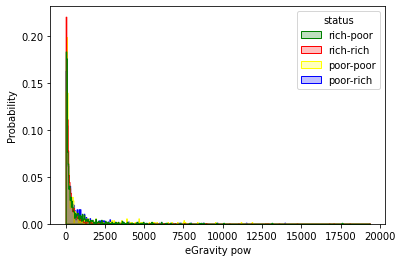

New York - Gravity exp


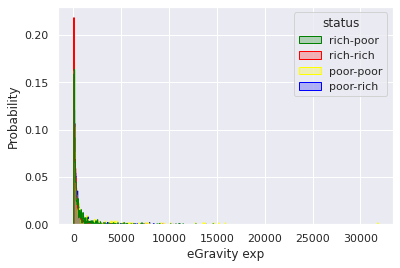

New York - Radiation


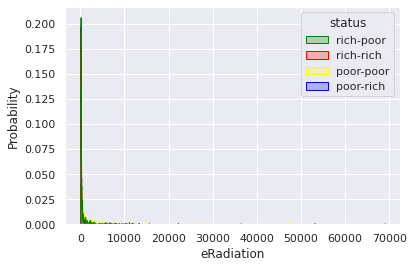

New York - Deep Gravity


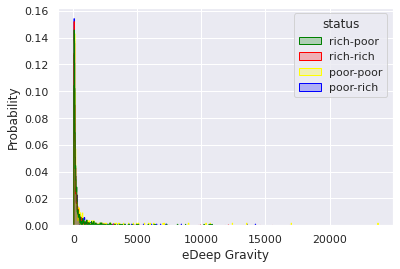

New York - Random Forest


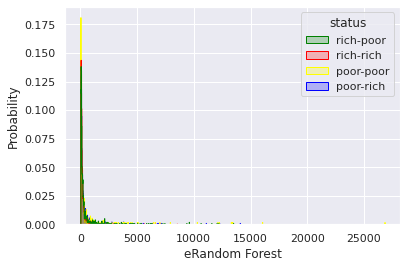

New York - BMS Plausible


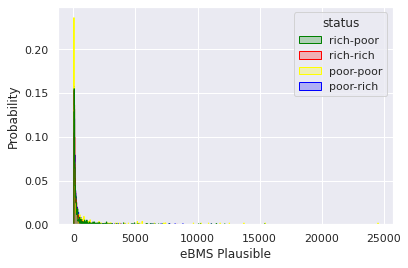

New York - BMS Ensemble


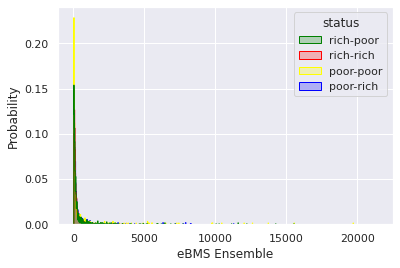

New York - BMS Predictive


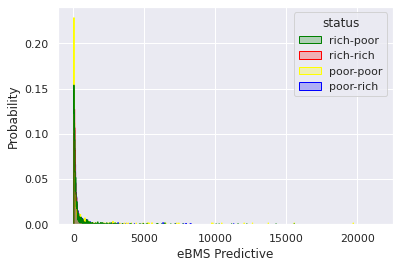

Massachusetts - Gravity pow


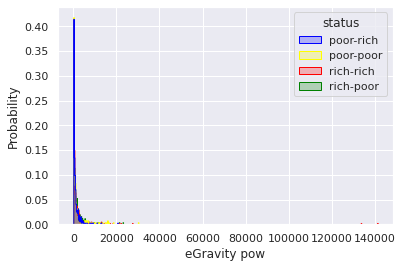

Massachusetts - Gravity exp


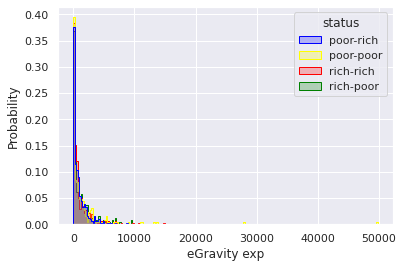

Massachusetts - Radiation


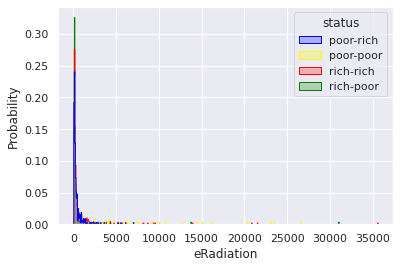

Massachusetts - Deep Gravity


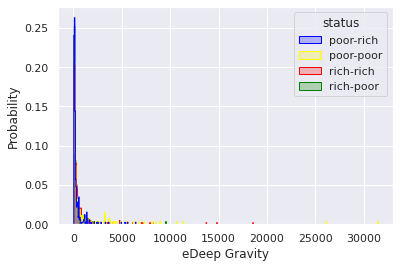

Massachusetts - Random Forest


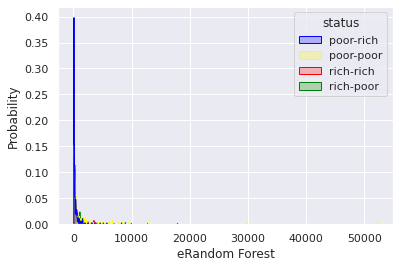

Massachusetts - BMS Plausible


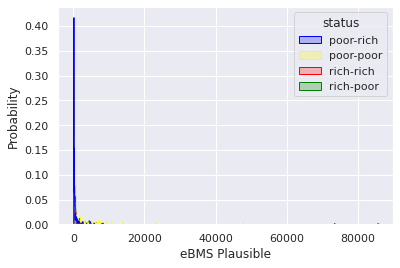

Massachusetts - BMS Ensemble


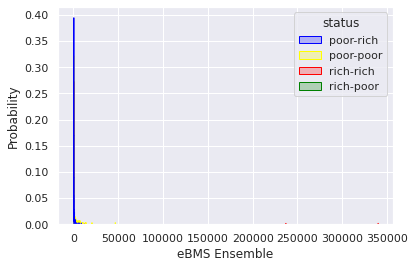

Massachusetts - BMS Predictive


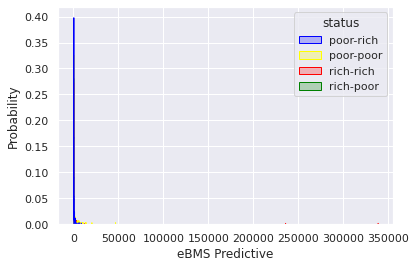

California - Gravity pow


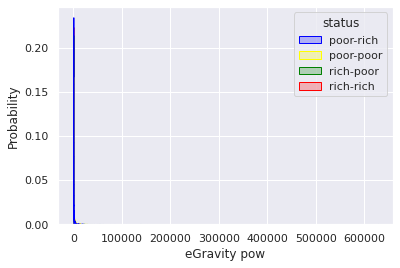

California - Gravity exp


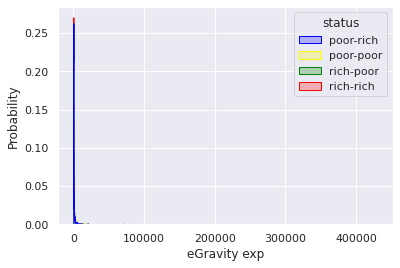

California - Radiation


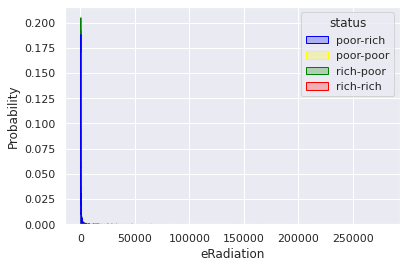

California - Deep Gravity


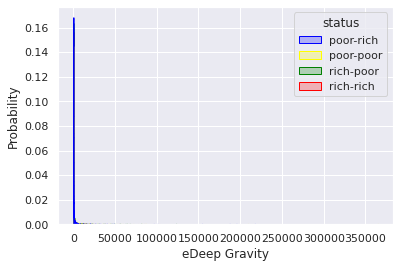

California - Random Forest


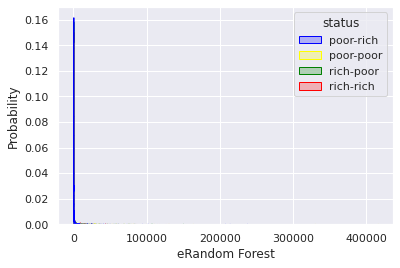

California - BMS Plausible


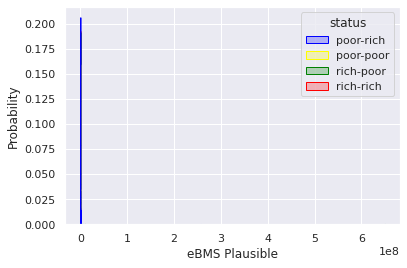

California - BMS Ensemble


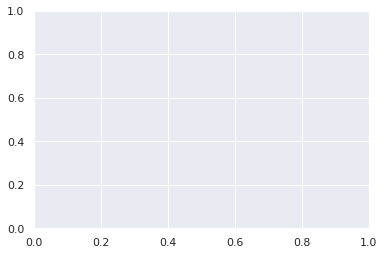

California - BMS Predictive


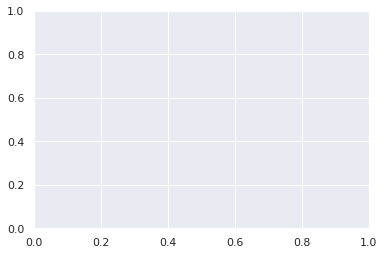

Florida - Gravity pow


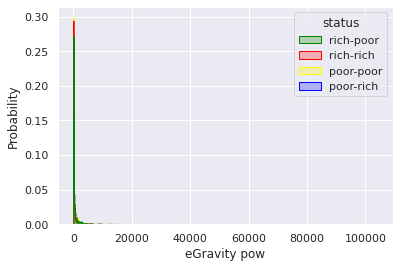

Florida - Gravity exp


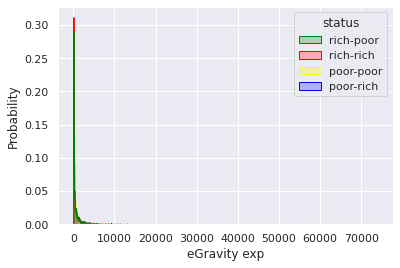

Florida - Radiation


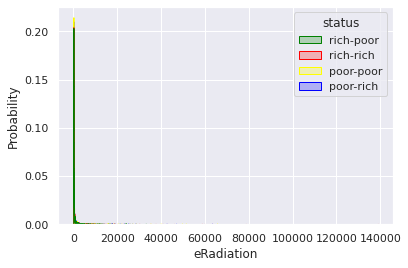

Florida - Deep Gravity


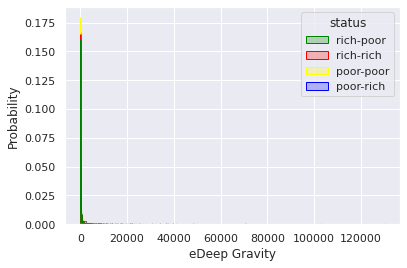

Florida - Random Forest


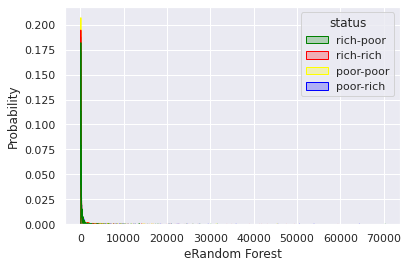

Florida - BMS Plausible


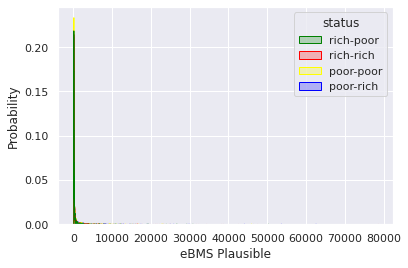

Florida - BMS Ensemble


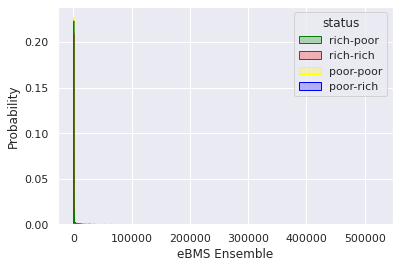

Florida - BMS Predictive


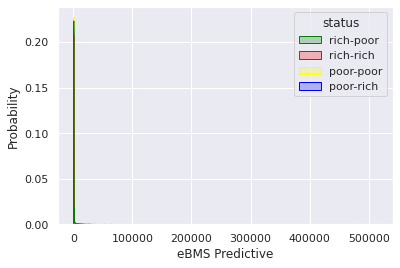

Washington - Gravity pow


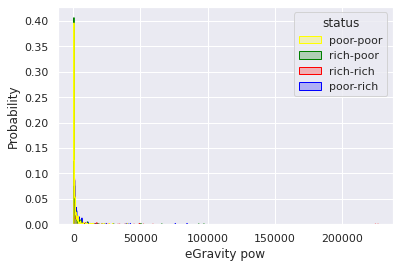

Washington - Gravity exp


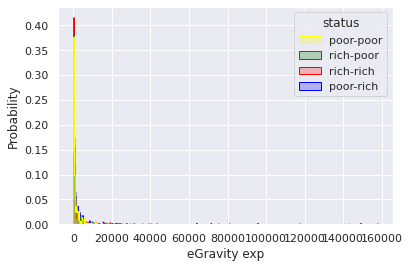

Washington - Radiation


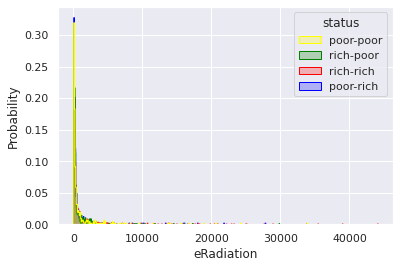

Washington - Deep Gravity


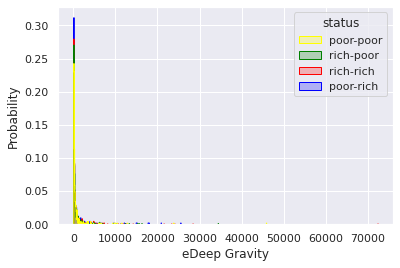

Washington - Random Forest


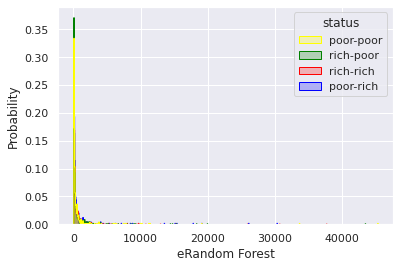

Washington - BMS Plausible


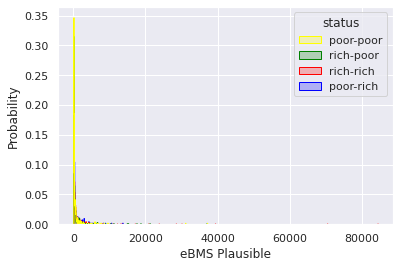

Washington - BMS Ensemble


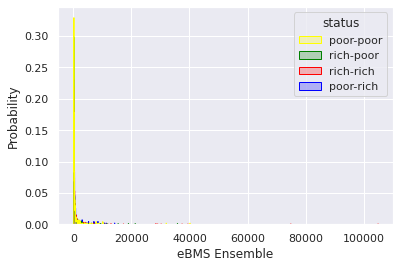

Washington - BMS Predictive


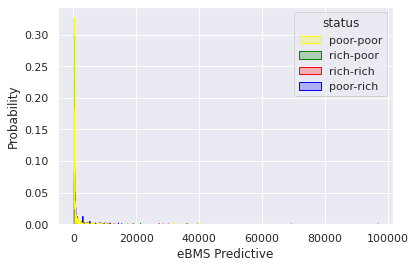

Texas - Gravity pow


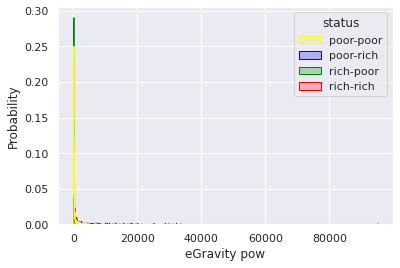

Texas - Gravity exp


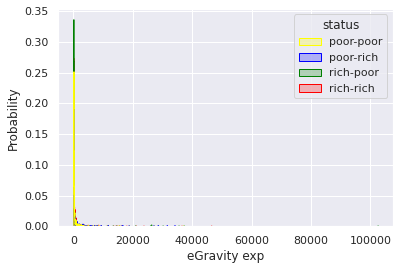

Texas - Radiation


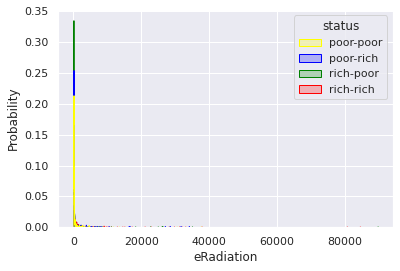

Texas - Deep Gravity


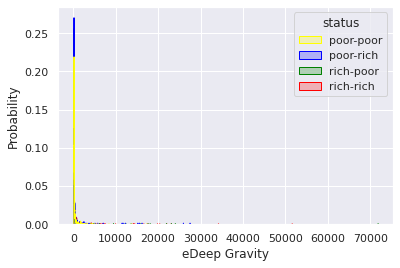

Texas - Random Forest


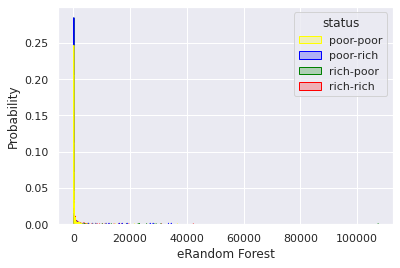

Texas - BMS Plausible


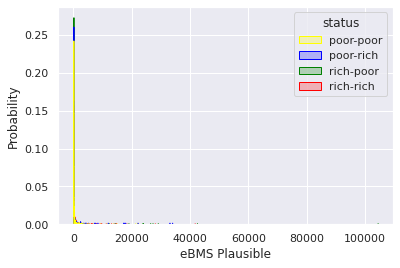

Texas - BMS Ensemble


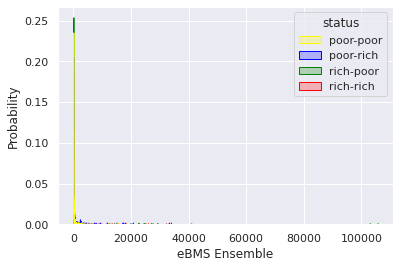

Texas - BMS Predictive


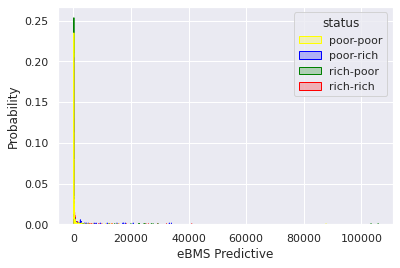

In [4]:
histograms_error_func(AbsErr)

New York
Gravity exp
BMS Ensemble
AxesSubplot(0.125,0.125;0.110714x0.755)
Massachusetts
Gravity exp
BMS Ensemble
AxesSubplot(0.257857,0.125;0.110714x0.755)
California
Gravity exp
BMS Ensemble
AxesSubplot(0.390714,0.125;0.110714x0.755)
Florida
Gravity exp
BMS Ensemble
AxesSubplot(0.523571,0.125;0.110714x0.755)
Washington
Gravity exp
BMS Ensemble
AxesSubplot(0.656429,0.125;0.110714x0.755)
Texas
Gravity exp
BMS Ensemble
AxesSubplot(0.789286,0.125;0.110714x0.755)
[<matplotlib.lines.Line2D object at 0x7fc5606c30d0>, <matplotlib.lines.Line2D object at 0x7fc5606c3c10>, <matplotlib.lines.Line2D object at 0x7fc5608d1130>, <matplotlib.lines.Line2D object at 0x7fc5606c35e0>, <matplotlib.lines.Line2D object at 0x7fc56077ae20>, <matplotlib.lines.Line2D object at 0x7fc56077a220>] ['Gravity pow', 'Radiation', 'BMS Plausible', 'BMS Predictive', 'Random Forest', 'Deep Gravity']


<Figure size 432x288 with 0 Axes>

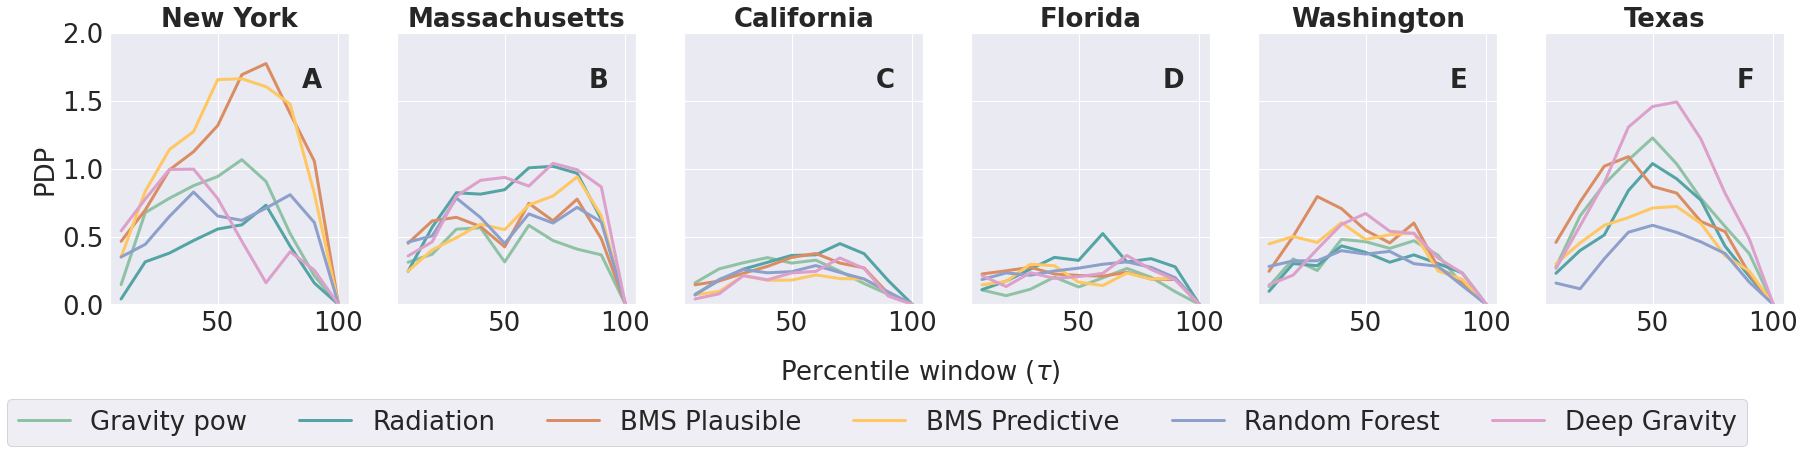

In [5]:
PDP(AbsErr)

New York - Gravity pow


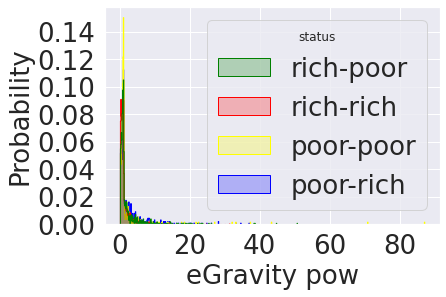

New York - Gravity exp


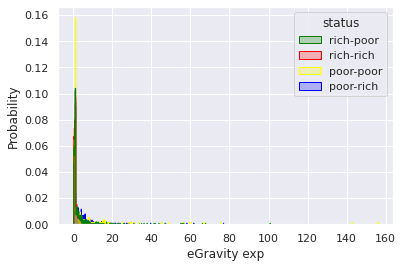

New York - Radiation


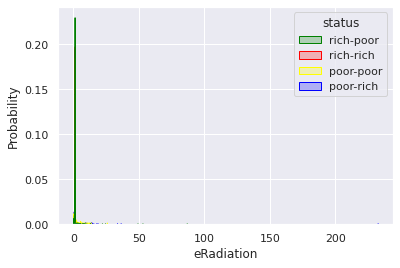

New York - Deep Gravity


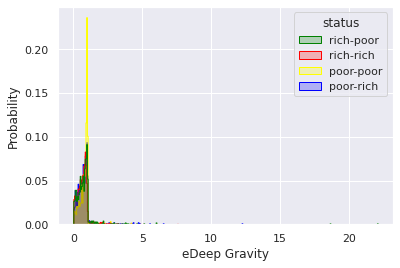

New York - Random Forest


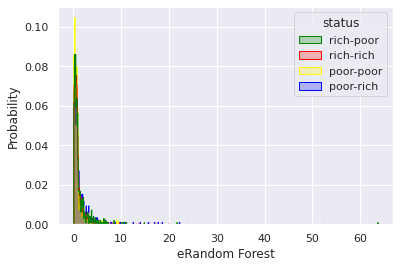

New York - BMS Plausible


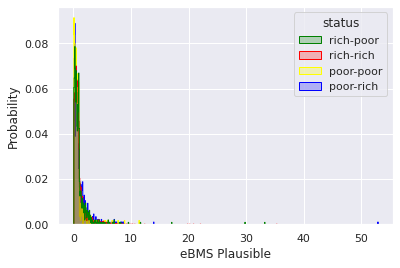

New York - BMS Ensemble


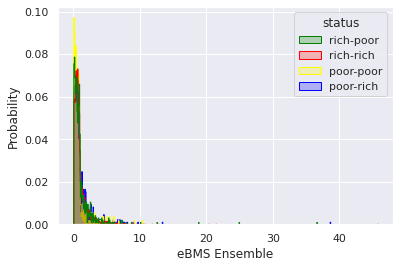

New York - BMS Predictive


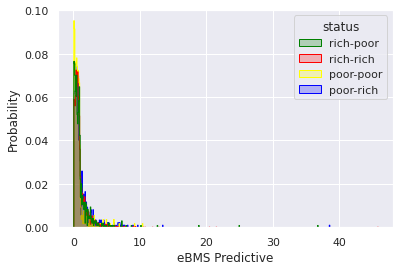

Massachusetts - Gravity pow


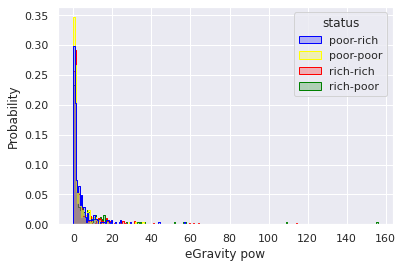

Massachusetts - Gravity exp


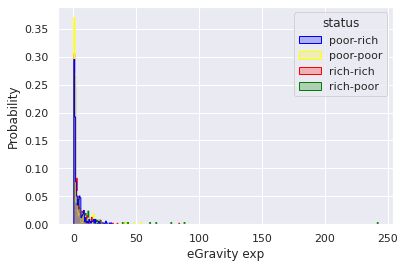

Massachusetts - Radiation


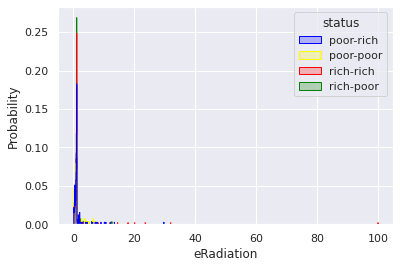

Massachusetts - Deep Gravity


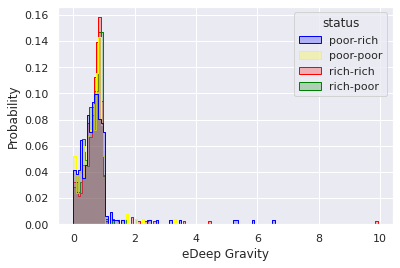

Massachusetts - Random Forest


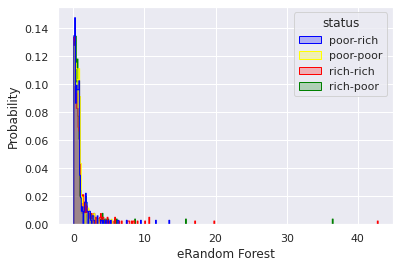

Massachusetts - BMS Plausible


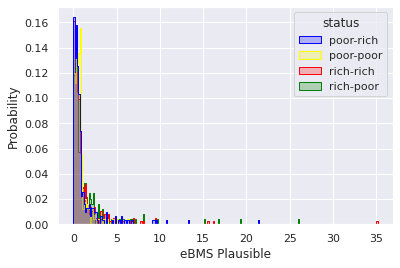

Massachusetts - BMS Ensemble


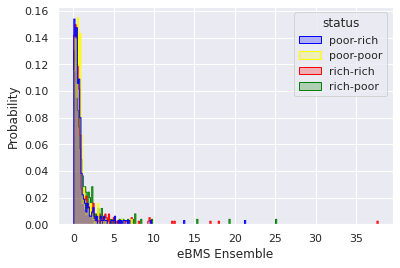

Massachusetts - BMS Predictive


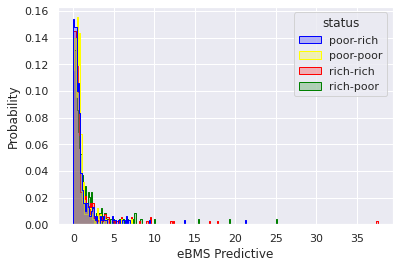

California - Gravity pow


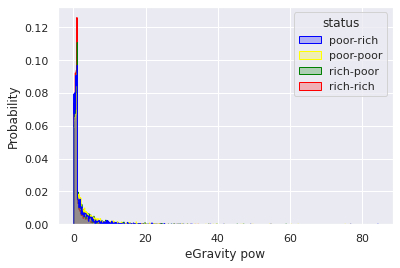

California - Gravity exp


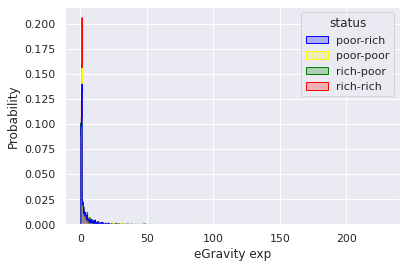

California - Radiation


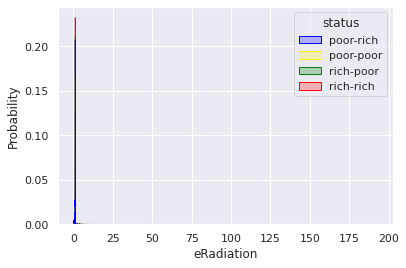

California - Deep Gravity


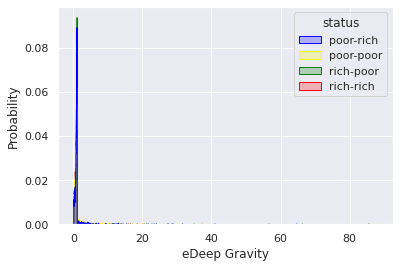

California - Random Forest


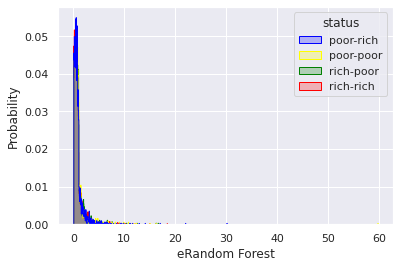

California - BMS Plausible


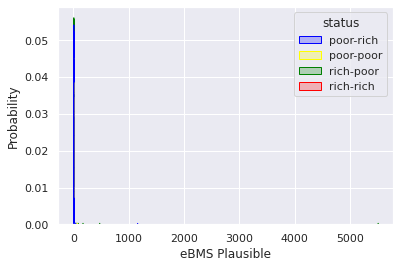

California - BMS Ensemble


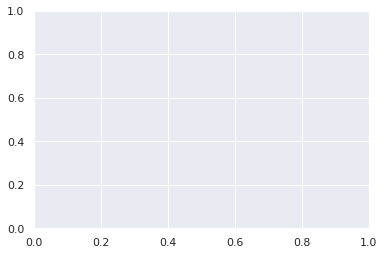

California - BMS Predictive


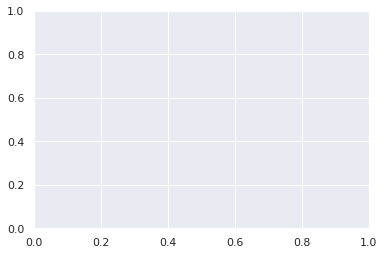

Florida - Gravity pow


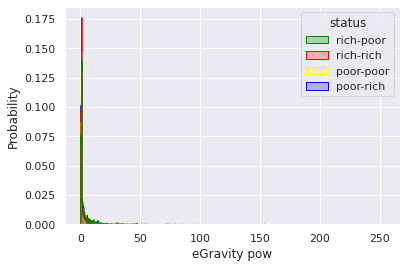

Florida - Gravity exp


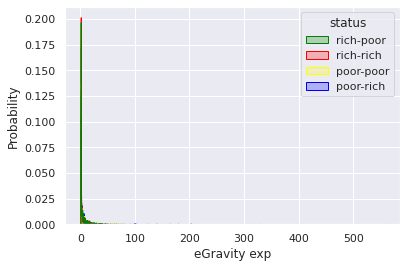

Florida - Radiation


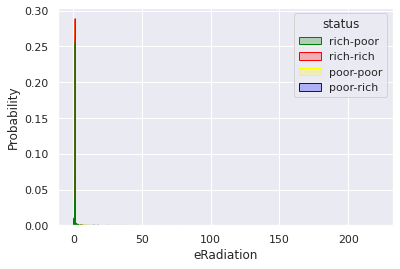

Florida - Deep Gravity


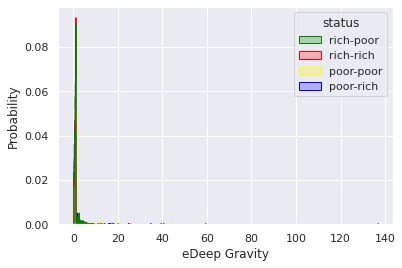

Florida - Random Forest


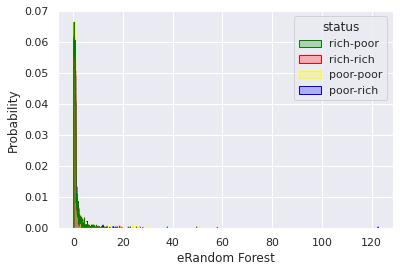

Florida - BMS Plausible


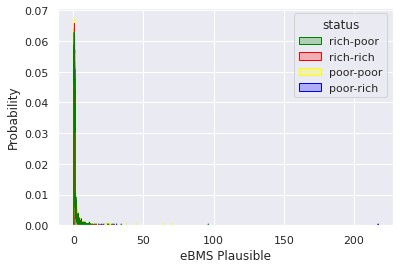

Florida - BMS Ensemble


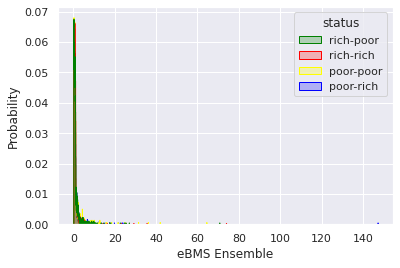

Florida - BMS Predictive


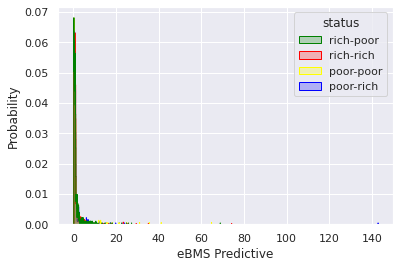

Washington - Gravity pow


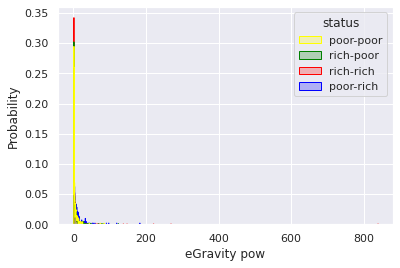

Washington - Gravity exp


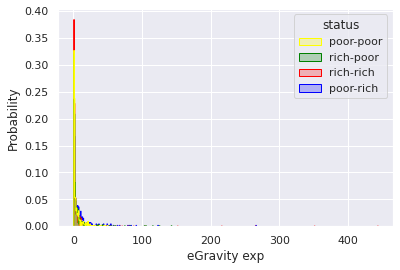

Washington - Radiation


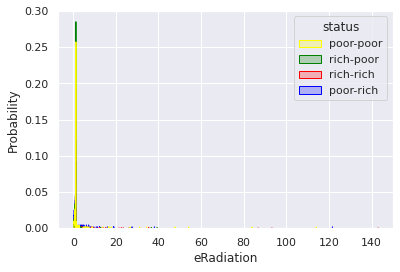

Washington - Deep Gravity


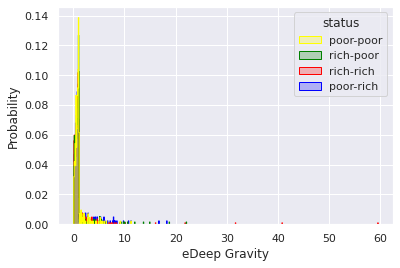

Washington - Random Forest


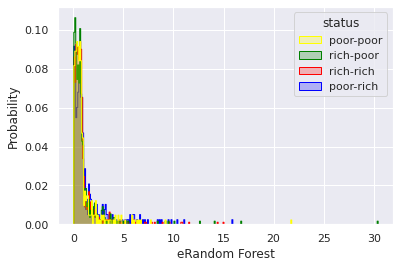

Washington - BMS Plausible


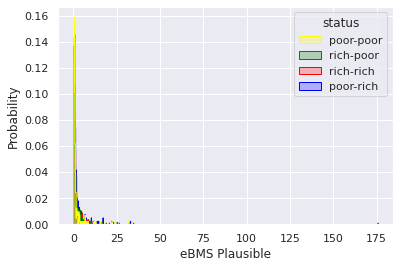

Washington - BMS Ensemble


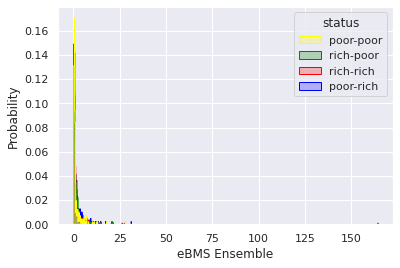

Washington - BMS Predictive


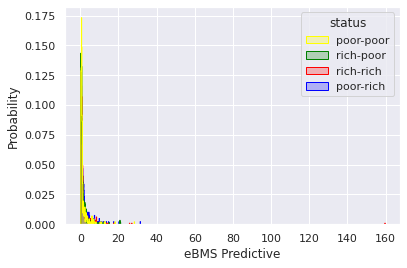

Texas - Gravity pow


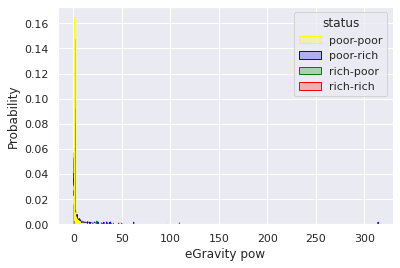

Texas - Gravity exp


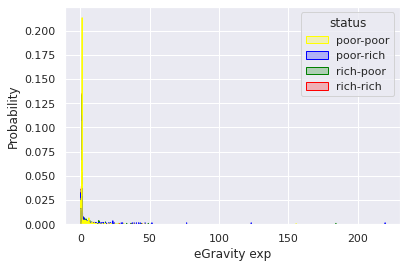

Texas - Radiation


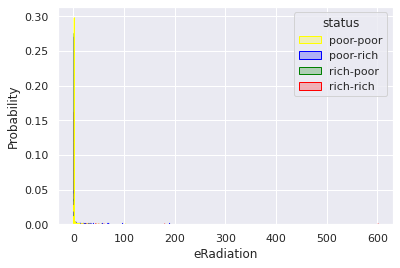

Texas - Deep Gravity


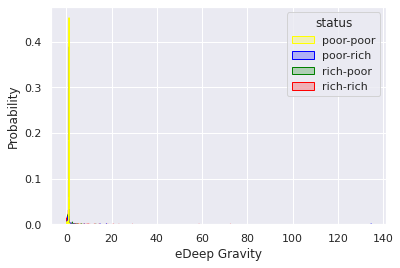

Texas - Random Forest


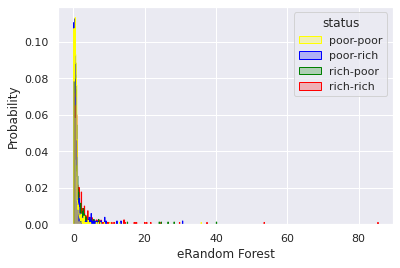

Texas - BMS Plausible


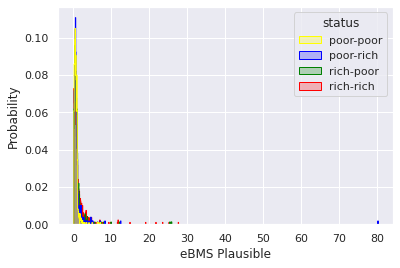

Texas - BMS Ensemble


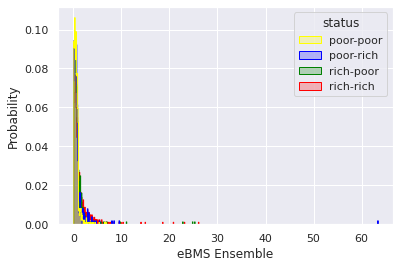

Texas - BMS Predictive


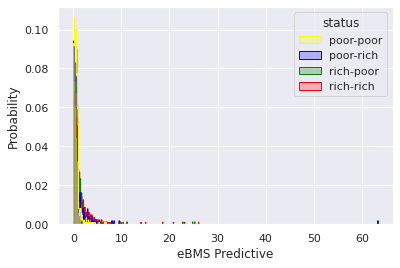

In [6]:
histograms_error_func(RE)

New York
Gravity exp
BMS Ensemble
AxesSubplot(0.125,0.125;0.110714x0.755)
Massachusetts
Gravity exp
BMS Ensemble
AxesSubplot(0.257857,0.125;0.110714x0.755)
California
Gravity exp
BMS Ensemble
AxesSubplot(0.390714,0.125;0.110714x0.755)
Florida
Gravity exp
BMS Ensemble
AxesSubplot(0.523571,0.125;0.110714x0.755)
Washington
Gravity exp
BMS Ensemble
AxesSubplot(0.656429,0.125;0.110714x0.755)
Texas
Gravity exp
BMS Ensemble
AxesSubplot(0.789286,0.125;0.110714x0.755)
[<matplotlib.lines.Line2D object at 0x7fc5605e8490>, <matplotlib.lines.Line2D object at 0x7fc5605e8100>, <matplotlib.lines.Line2D object at 0x7fc5605e8640>, <matplotlib.lines.Line2D object at 0x7fc5605e8280>, <matplotlib.lines.Line2D object at 0x7fc5605e8d30>, <matplotlib.lines.Line2D object at 0x7fc5605e8880>] ['Gravity pow', 'Radiation', 'BMS Plausible', 'BMS Predictive', 'Random Forest', 'Deep Gravity']


<Figure size 432x288 with 0 Axes>

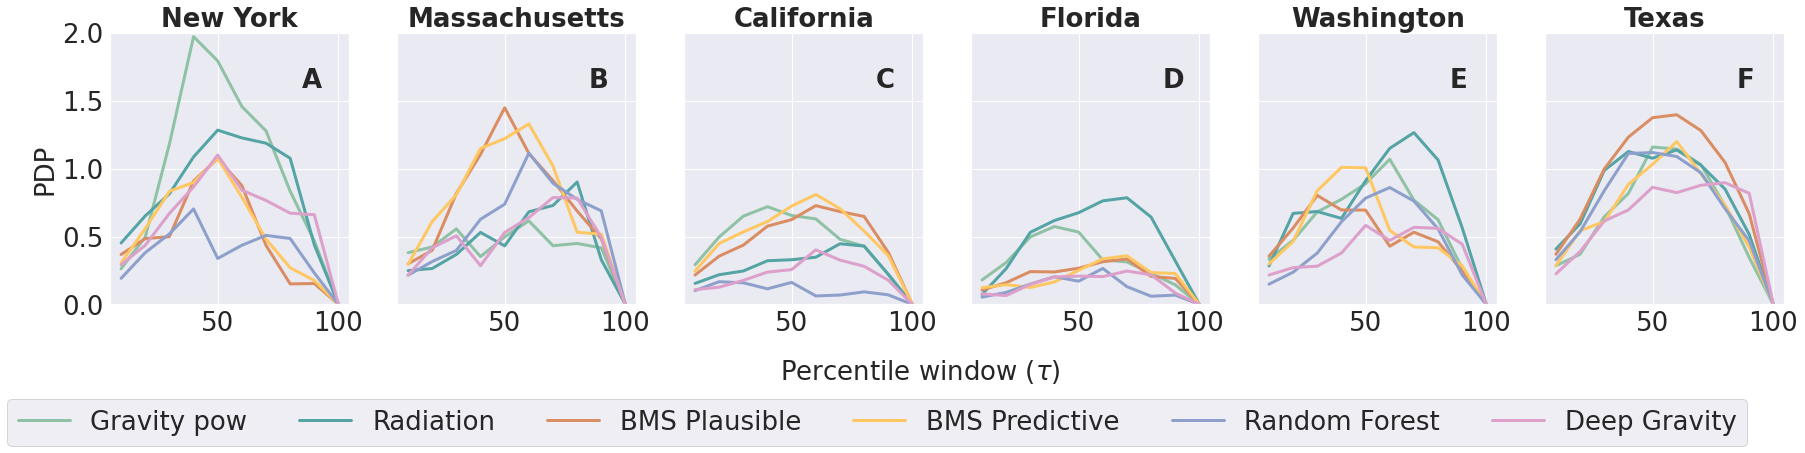

In [7]:
PDP(RE)

New York - Gravity pow


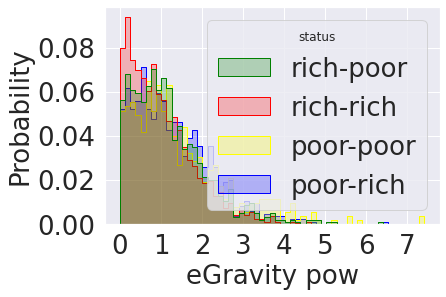

New York - Gravity exp


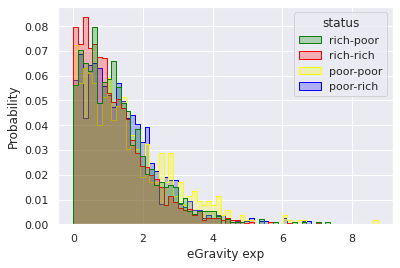

New York - Radiation


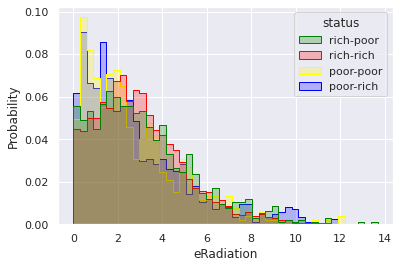

New York - Deep Gravity


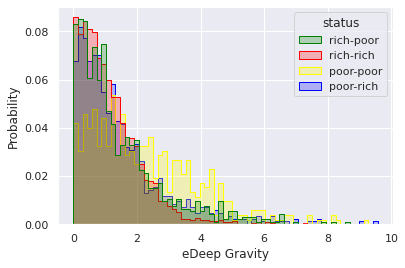

New York - Random Forest


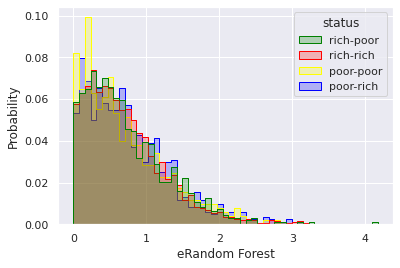

New York - BMS Plausible


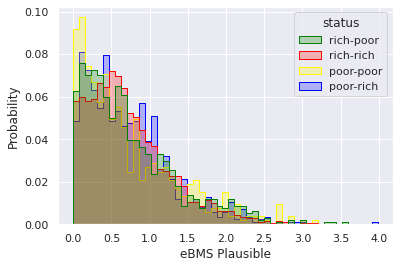

New York - BMS Ensemble


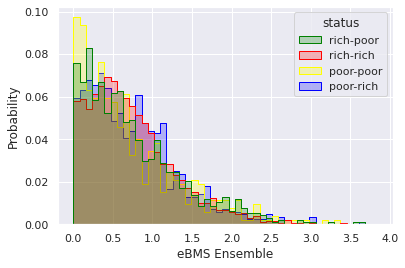

New York - BMS Predictive


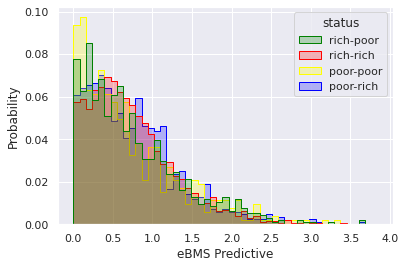

Massachusetts - Gravity pow


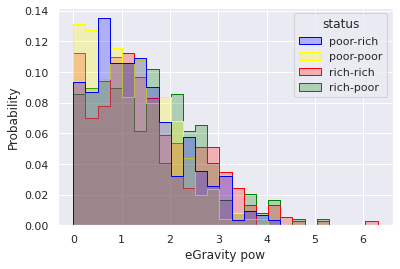

Massachusetts - Gravity exp


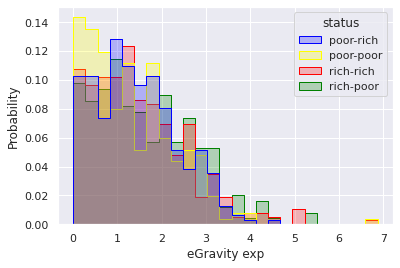

Massachusetts - Radiation


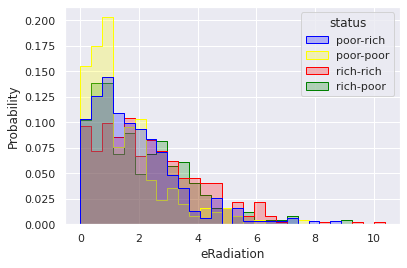

Massachusetts - Deep Gravity


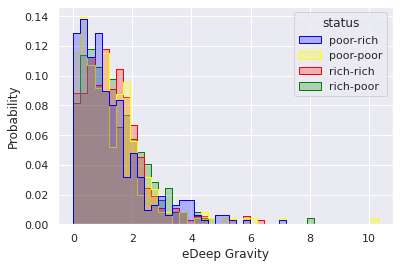

Massachusetts - Random Forest


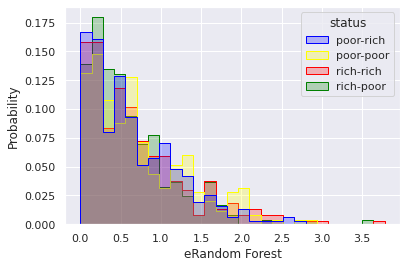

Massachusetts - BMS Plausible


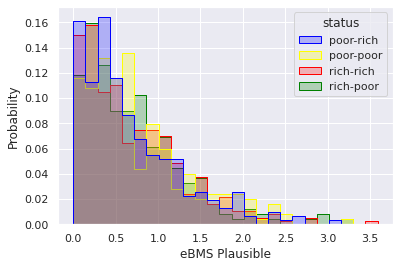

Massachusetts - BMS Ensemble


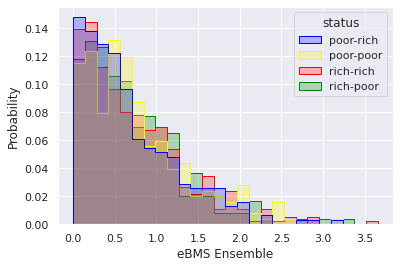

Massachusetts - BMS Predictive


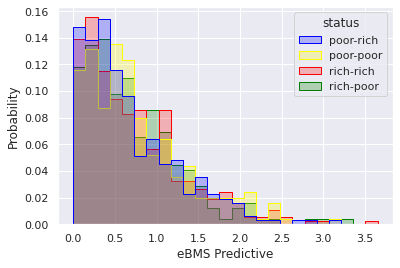

California - Gravity pow


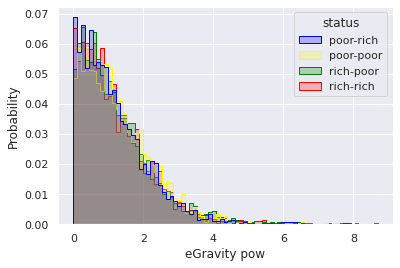

California - Gravity exp


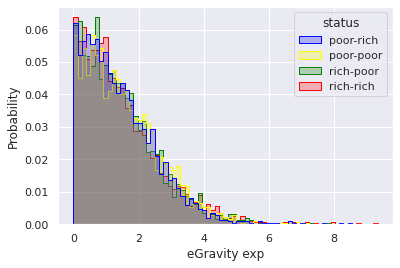

California - Radiation


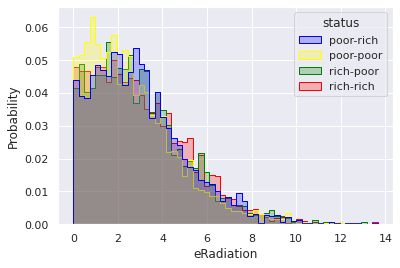

California - Deep Gravity


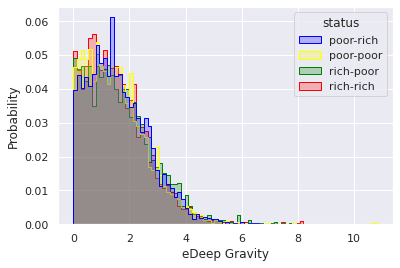

California - Random Forest


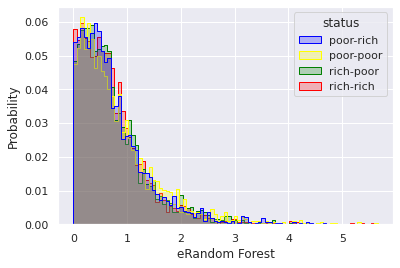

California - BMS Plausible


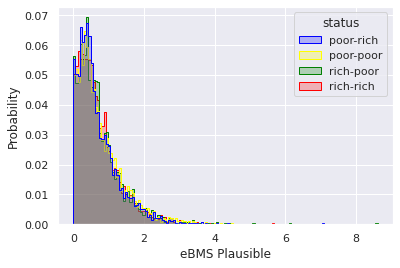

California - BMS Ensemble


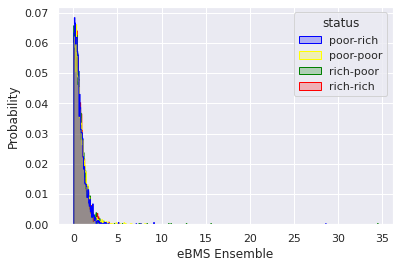

California - BMS Predictive


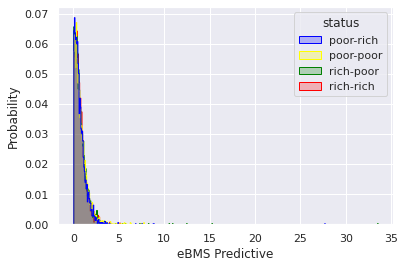

Florida - Gravity pow


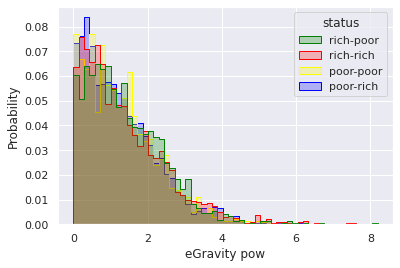

Florida - Gravity exp


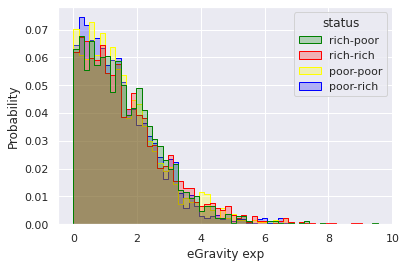

Florida - Radiation


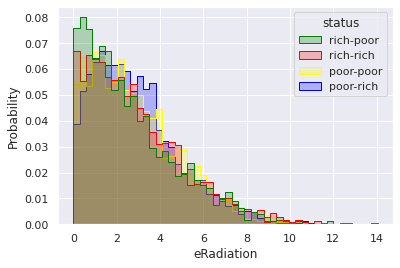

Florida - Deep Gravity


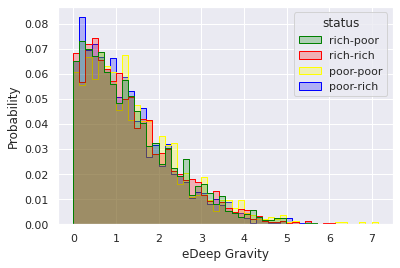

Florida - Random Forest


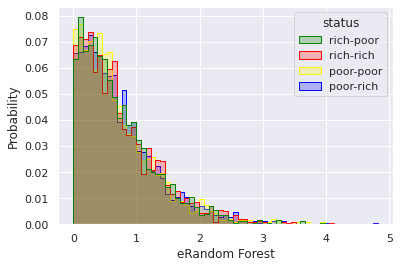

Florida - BMS Plausible


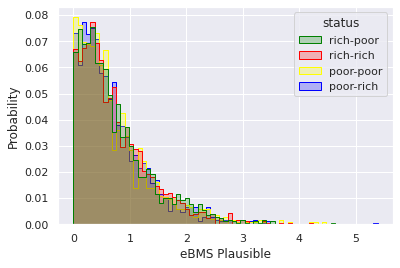

Florida - BMS Ensemble


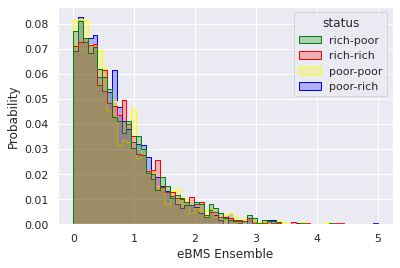

Florida - BMS Predictive


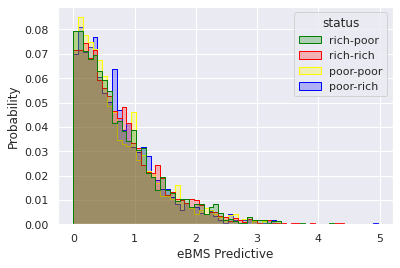

Washington - Gravity pow


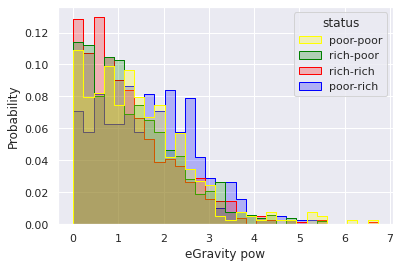

Washington - Gravity exp


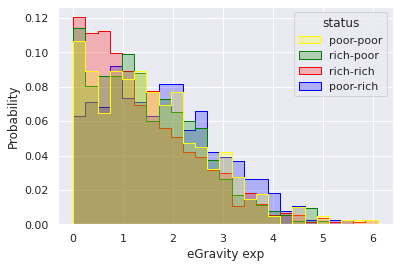

Washington - Radiation


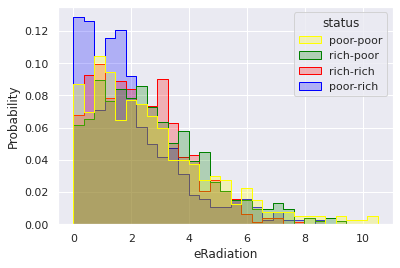

Washington - Deep Gravity


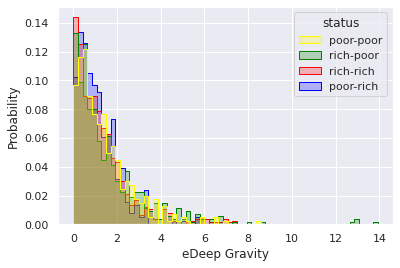

Washington - Random Forest


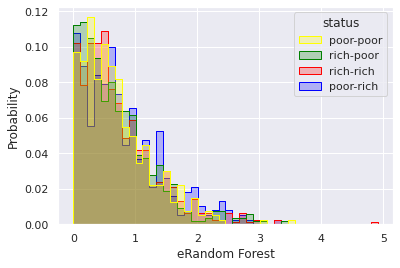

Washington - BMS Plausible


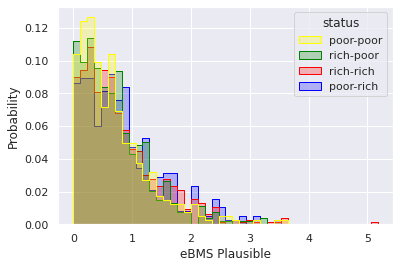

Washington - BMS Ensemble


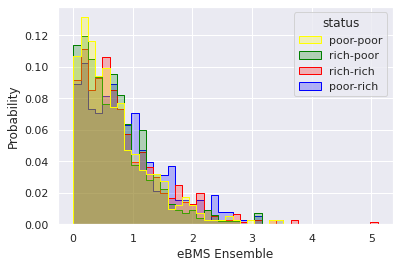

Washington - BMS Predictive


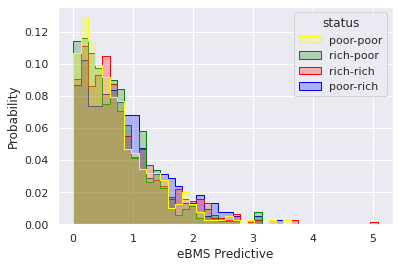

Texas - Gravity pow


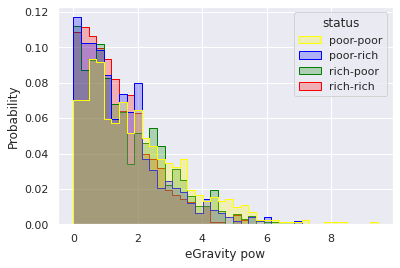

Texas - Gravity exp


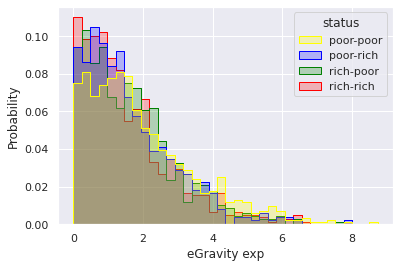

Texas - Radiation


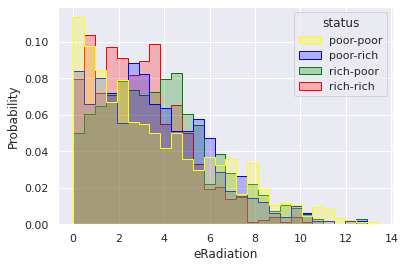

Texas - Deep Gravity


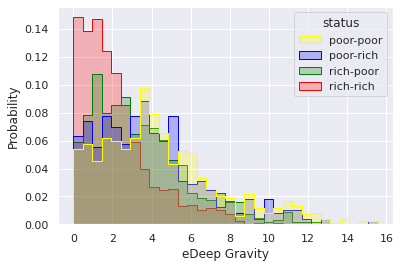

Texas - Random Forest


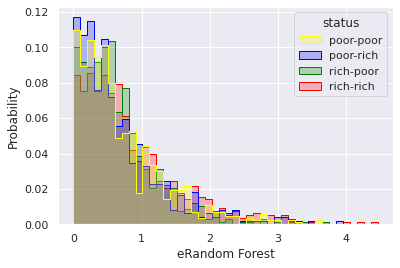

Texas - BMS Plausible


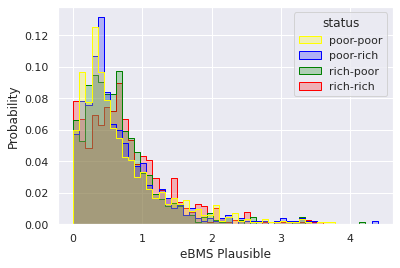

Texas - BMS Ensemble


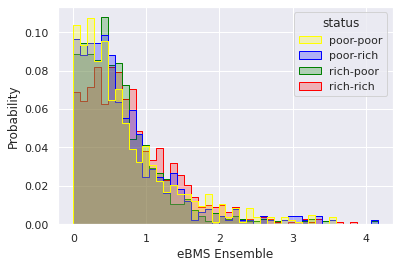

Texas - BMS Predictive


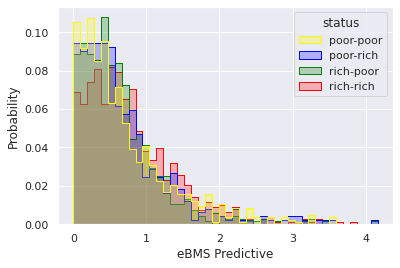

In [8]:
histograms_error_func(LogRatio)

New York
Gravity exp
BMS Ensemble
AxesSubplot(0.125,0.125;0.110714x0.755)
Massachusetts
Gravity exp
BMS Ensemble
AxesSubplot(0.257857,0.125;0.110714x0.755)
California
Gravity exp
BMS Ensemble
AxesSubplot(0.390714,0.125;0.110714x0.755)
Florida
Gravity exp
BMS Ensemble
AxesSubplot(0.523571,0.125;0.110714x0.755)
Washington
Gravity exp
BMS Ensemble
AxesSubplot(0.656429,0.125;0.110714x0.755)
Texas
Gravity exp
BMS Ensemble
AxesSubplot(0.789286,0.125;0.110714x0.755)
[<matplotlib.lines.Line2D object at 0x7fc5605fe340>, <matplotlib.lines.Line2D object at 0x7fc5605fe520>, <matplotlib.lines.Line2D object at 0x7fc5605fe610>, <matplotlib.lines.Line2D object at 0x7fc5605fe9a0>, <matplotlib.lines.Line2D object at 0x7fc5605fedf0>, <matplotlib.lines.Line2D object at 0x7fc5608650a0>] ['Gravity pow', 'Radiation', 'BMS Plausible', 'BMS Predictive', 'Random Forest', 'Deep Gravity']


<Figure size 432x288 with 0 Axes>

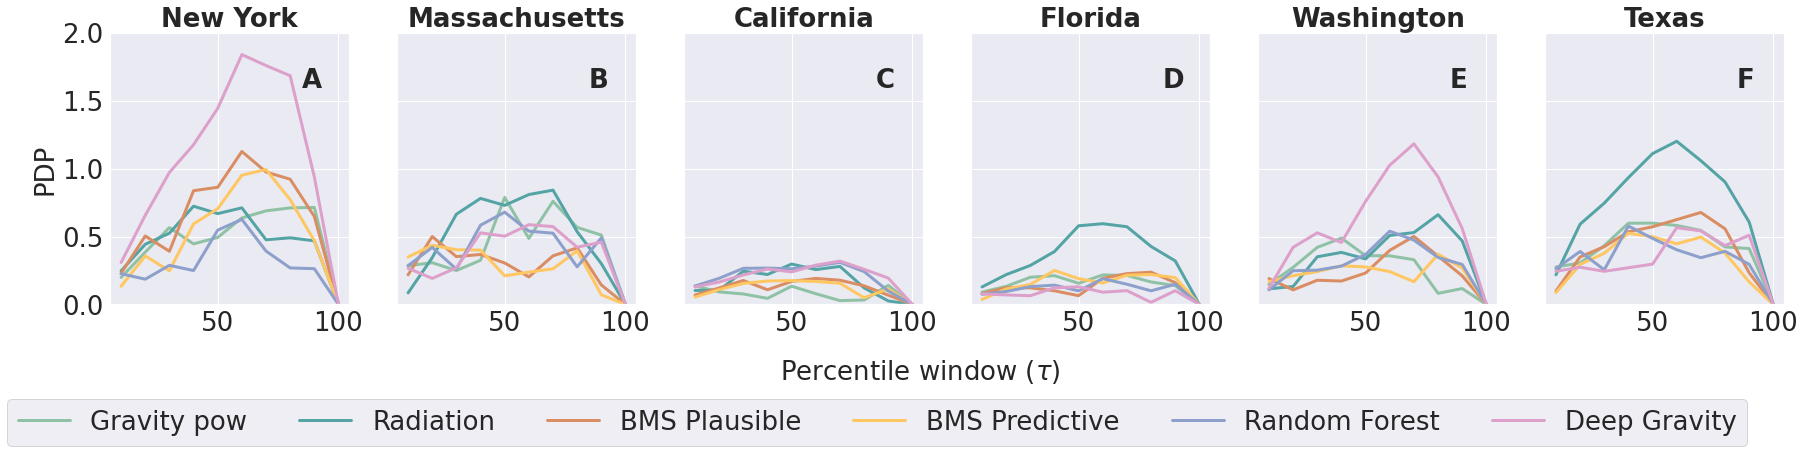

In [9]:
PDP(LogRatio)